In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS =3
EPOCHS = 20

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 1 0 0 1 1 1 0 0 0 2 0 1 1 1 0 2 1 0 1 0 1 0 0 0 2 0 0 1 2]


2025-11-04 00:04:17.279255: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-11-04 00:04:17.327482: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


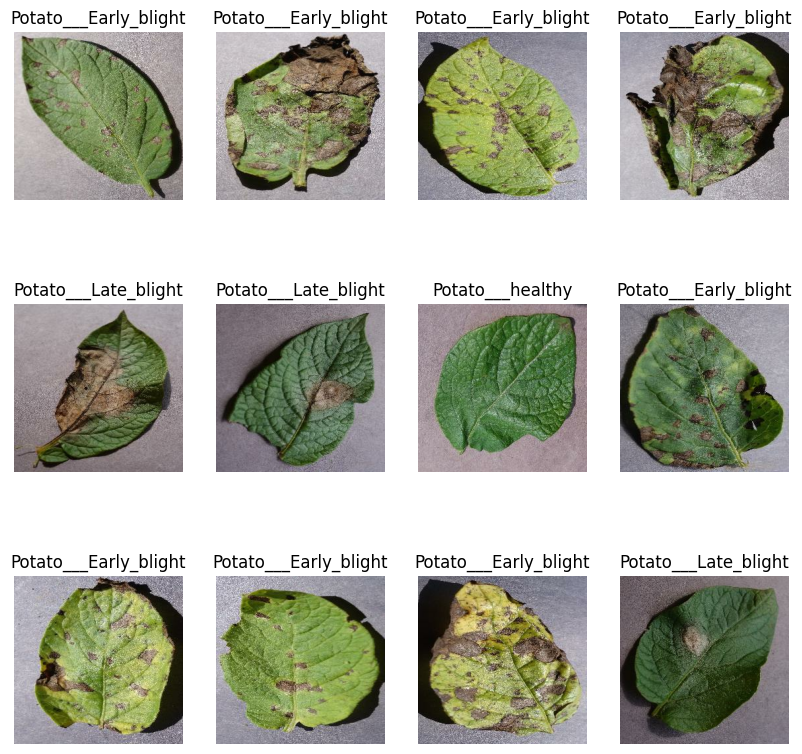

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('Off')

### 80% ==> traning
### 20% ==> 10% Validations, 10% Test

In [10]:
len(dataset) # basically actual length will be 32*68

68

In [11]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [12]:
train_ds = dataset.take(54) ## arr[:54] first 54 data
len(train_ds)  ## Train dataset

54

In [13]:
test_ds=dataset.skip(54) # arr[54:]
len(test_ds)

14

In [14]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6) ## Our actual test dataset
len(test_ds)

8

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split = 0.1, shuffle =True, shuffle_size =10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

        train_size = int(train_split * ds_size)
        val_size = int(val_split * ds_size)

        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).skip(val_size)

        return train_ds, val_ds, test_ds

In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Apply preprocessing and data augmentation to the datasets using tf.image
def preprocess_image(image, label, training):
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = image / 255.0  # Rescale
    if training:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)) # Random 90 degree rotations
    return image, label

train_ds = train_ds.map(lambda x, y: preprocess_image(x, y, training=True))
val_ds = val_ds.map(lambda x, y: preprocess_image(x, y, training=False))
test_ds = test_ds.map(lambda x, y: preprocess_image(x, y, training=False))

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

### Model training

In [24]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    tf.keras.Input(shape=input_shape), # Add Input layer here
    # Remove resize_and_rescale and data_augmentation from the model
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
# model.build(input_shape=(None, *input_shape)) # Remove this line

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1
)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 359ms/step - accuracy: 0.4977 - loss: 0.9061 - val_accuracy: 0.6979 - val_loss: 0.7341
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 341ms/step - accuracy: 0.6701 - loss: 0.7739 - val_accuracy: 0.7917 - val_loss: 0.5144
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 341ms/step - accuracy: 0.7957 - loss: 0.5000 - val_accuracy: 0.9062 - val_loss: 0.2946
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 332ms/step - accuracy: 0.8779 - loss: 0.3470 - val_accuracy: 0.9167 - val_loss: 0.2193
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 348ms/step - accuracy: 0.8900 - loss: 0.2755 - val_accuracy: 0.9219 - val_loss: 0.1779
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 340ms/step - accuracy: 0.9097 - loss: 0.2130 - val_accuracy: 0.9219 - val_loss: 0.2411
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 341ms/step - accuracy: 0.9288 - loss: 0.1884 - val_accuracy: 0.9062 - val_loss: 0.2330
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 343ms/step - accuracy: 0.9462 - loss: 0.1603 - val_accu

In [29]:
score = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9741 - loss: 0.0655


In [30]:
score

[0.0655050054192543, 0.9741379022598267]

In [31]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [33]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

<module 'matplotlib.pyplot' from '/opt/homebrew/lib/python3.11/site-packages/matplotlib/pyplot.py'>

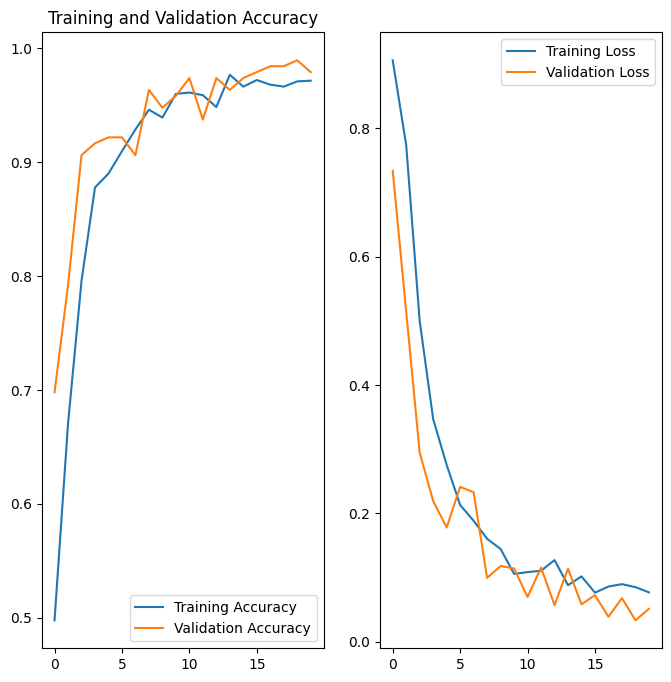

In [35]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt

first image to predict


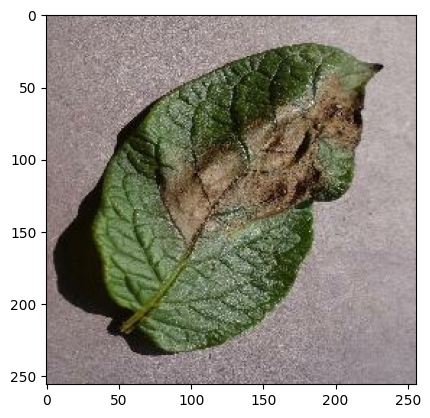

actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
predicted label: Potato___Early_blight


2025-11-04 00:10:32.422512: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [36]:
import numpy as np
# Create a version of the test dataset for visualization without normalization
test_ds_viz = dataset.skip(54).skip(6) # This assumes the original dataset is still available

for image_batch, labels_batch in test_ds_viz.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print('first image to predict')
    plt.imshow(first_image)
    plt.show()
    print('actual label:', class_names[first_label])

    # Use the normalized test_ds for prediction
    for image_batch_norm, labels_batch_norm in test_ds.take(1):
        batch_prediction = model.predict(image_batch_norm)
        print('predicted label:', class_names[np.argmax(batch_prediction[0])])

In [37]:
def predict(model, img):
  # Use tf.keras.utils.img_to_array instead of tf.keras.preprocessing.image_to_array
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) ## Create a batch

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


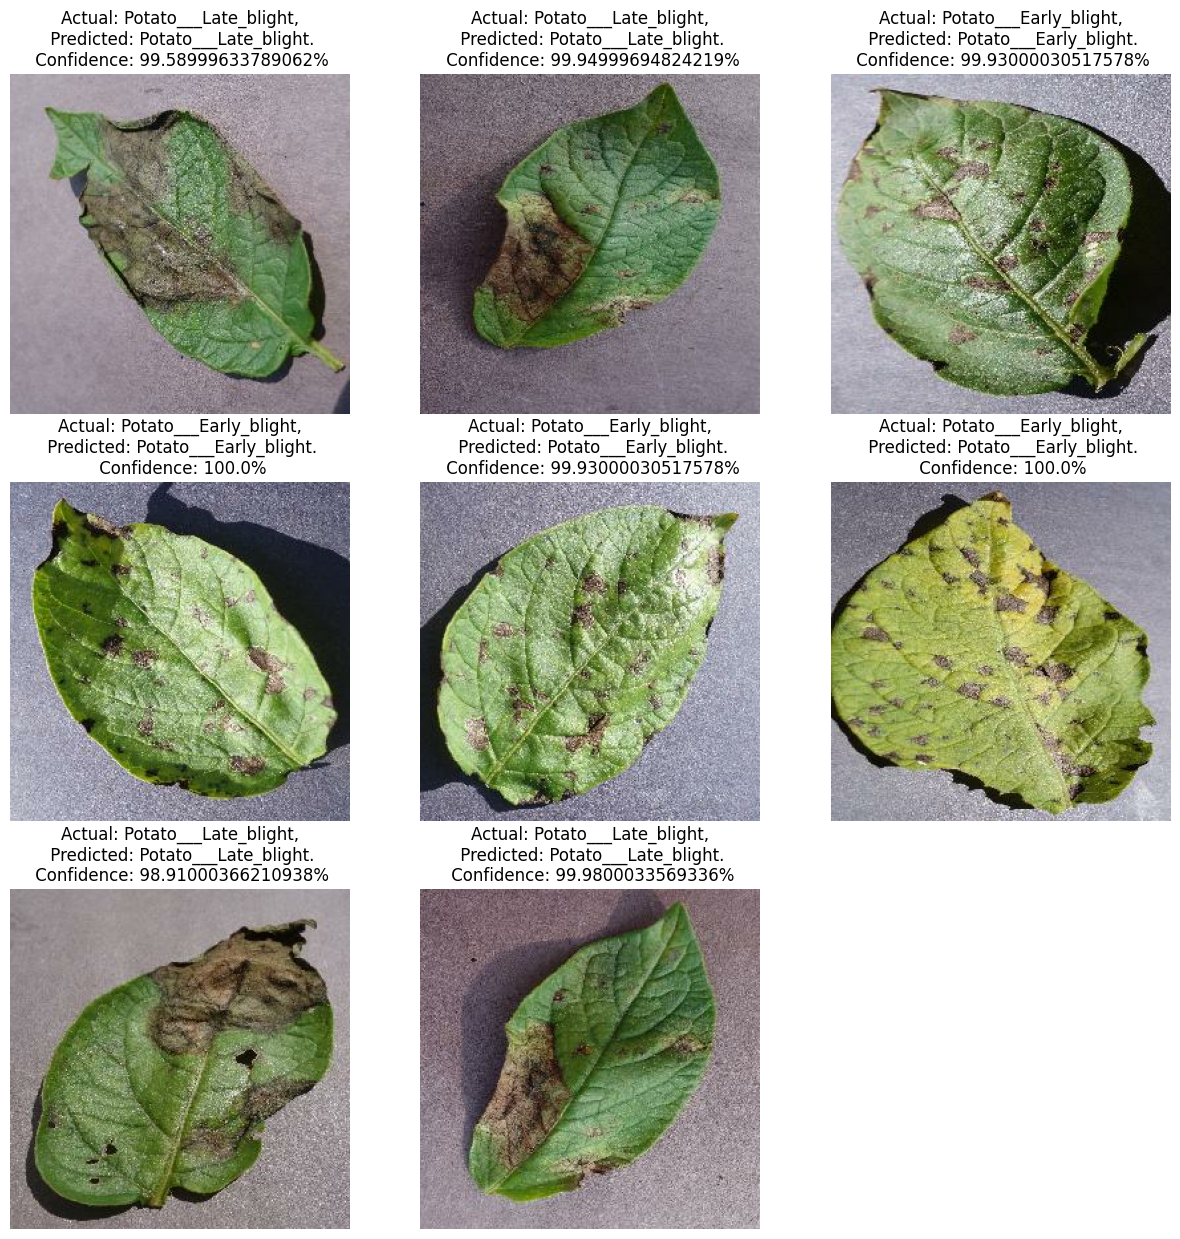

In [38]:
plt.figure(figsize=(15,15))
for image, batch_label in test_ds.take(1):
  # Iterate only up to the number of images in the batch
  for i in range(min(9, image.shape[0])):
    ax = plt.subplot(3,3,i+1)
    # Ensure the image is in the correct format for display
    plt.imshow((image[i].numpy() * 255).astype('uint8'))

    predicted_class, confidence = predict(model, image[i].numpy())
    actual_class = class_names[batch_label[i]]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

    plt.axis('off')

In [ ]:
import os

model_dir = "/Users/priyanshuyadav/Desktop/Deep Learning Project/models"
os.makedirs(model_dir, exist_ok=True)

# Extract numeric parts safely
versions = []
for name in os.listdir(model_dir):
    if name.startswith("model_v") and name.endswith(".keras"):
        try:
            versions.append(int(name.split("model_v")[1].split(".keras")[0]))
        except ValueError:
            pass

# Determine next version
model_version = max(versions, default=0) + 1

# Save path
save_path = f"{model_dir}/model_v{model_version}.keras"
model.save(save_path)

print(f" Model saved successfully as version {model_version} at:\n{save_path}")



✅ Model saved successfully as version 1 at:
/Users/priyanshuyadav/Desktop/Deep Learning Project/models/model_v1.keras
